# Evaluating the neuron quality
### Take the data from the neuronal segmentation pipeline and evaluate which neurons are good, save results

In [1]:
# Load the libraries
import caiman as cm
from caiman.source_extraction import cnmf

import matplotlib.pyplot as plt
from matplotlib.widgets import Button, TextBox
from matplotlib.patches import Polygon
from matplotlib.path import Path
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import json
from scipy.sparse import csc_matrix
from scipy.stats import sem
from scipy import stats
import statistics

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import linear_model as lm

import cv2
from itertools import compress

from IPython import get_ipython
import IPython

from ipyfilechooser import FileChooser

from scipy.ndimage import binary_erosion
from scipy.ndimage import grey_erosion

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

Load the data

In [2]:
# Set the starting folder
start_path = 'D:\CaIm'
%cd $start_path

# Create and display a FileChooser widget
fc = FileChooser(start_path)
fc.use_dir_icons = True
display(fc)

D:\CaIm


FileChooser(path='D:\CaIm', filename='', title='', show_hidden=False, select_desc='Select', change_desc='Chang…

In [3]:
# Load the data
#path = 'D:/CaIm/os80/b2/'
path = fc.selected_path + '\\'

traces_path = path + 'traces.json'
component_locations_path = path + 'component_locations.json'
filter_img_path = path + 'filter_img.json'
accepted_path = path + 'accepted.json'
with open(traces_path, 'r') as json_file:
    traces_list = json.load(json_file)
with open(component_locations_path, 'r') as json_file:
    component_locations_list = json.load(json_file)
with open(filter_img_path, 'r') as json_file:
    filter_img = json.load(json_file)
with open(accepted_path, 'r') as json_file:
    accepted_list = json.load(json_file)

# Convert to convinient formats
component_locations = np.array(component_locations_list)
component_locations_sparse = csc_matrix(component_locations)
traces = np.array(traces_list)
filter_img = np.array(filter_img)

# Load csv files with evaluated neurons
inside_neurons = pd.read_csv(path + 'inside_neurons.csv')
good_neurons = pd.read_csv(path + 'good_neurons.csv')
fair_neurons = pd.read_csv(path + 'fair_neurons.csv')

# Display the number of components total and the rejected ones
print(f"Total number of components: {traces.shape[0]}, accepted: {len(accepted_list)}")
      
# Select only accepted:
#component_locations = component_locations[:,accepted_list]
# traces = traces[accepted_list,:]

Total number of components: 753, accepted: 217


In [5]:
# Load csv files with evaluated neurons
is_inside = pd.read_csv(path + 'inside_neurons.csv')
good_neurons = pd.read_csv(path + 'good_neurons.csv')
fair_neurons = pd.read_csv(path + 'fair_neurons.csv')


In [6]:
is_inside=is_inside['Inside'].tolist()
fair_neurons = fair_neurons['Fair'].tolist()
good_neurons = good_neurons['Status'].tolist()
print(f"Now: {sum(is_inside)}")

Now: 246


## Discard components outside of the polygon

In [7]:
component_locs_sharp =[]
for n in np.arange(component_locations.shape[1]):
    comp = component_locations[:,n]
    comp_no0 = comp[comp>0]


    # because there are some weird component with just 1 point:
    if len(comp_no0) >= 2:
        mean_comp = np.mean(comp_no0)
        sd_comp = statistics.stdev(comp_no0)
        cutoff = mean_comp
        sharper = np.where(comp < cutoff, 0, comp)
        component_locs_sharp.append(sharper)
    else:
        component_locs_sharp.append(comp)
component_locs_sharp = np.array(component_locs_sharp)

## plot a neuron location on the overlay of the max image and a trace of this neuron

In [9]:
component_locations = component_locations[:, is_inside]
component_locs_sharp = component_locs_sharp[:][is_inside]
traces = traces[is_inside, :]

187 287 9 109


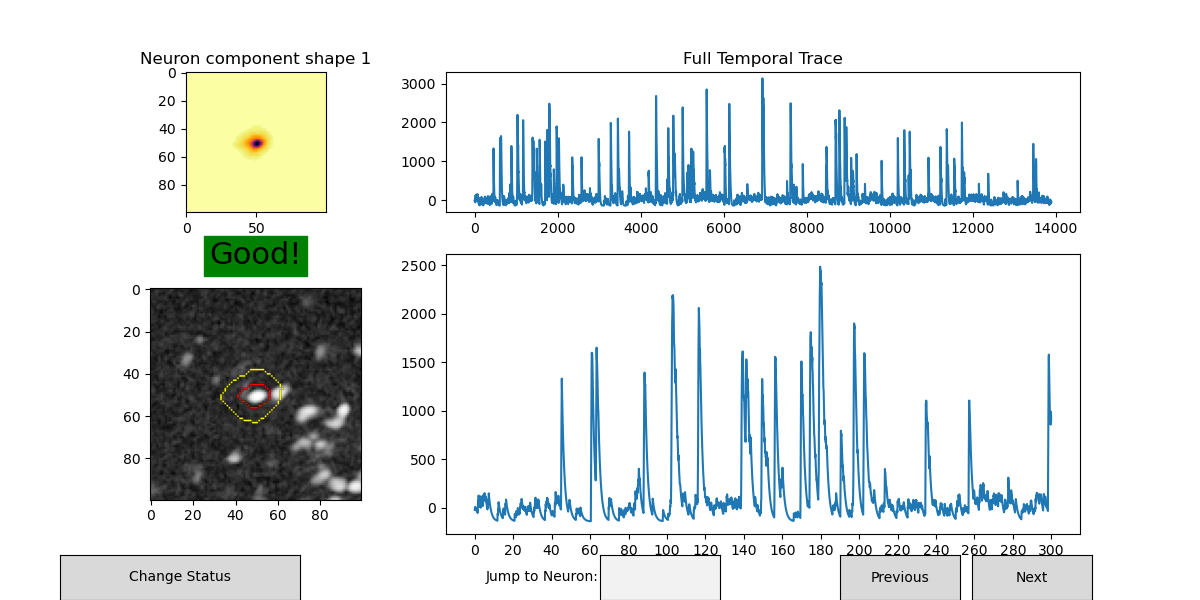

In [13]:
%matplotlib widget
d1 = filter_img.shape[1]
d2 = filter_img.shape[0]

# Initial component number
component_num = 0
fair_list = [0]*component_locations.shape[1]


status_array = np.zeros((component_locations.shape[1]), dtype=int)

# Plot a certain neuron
def update_plot(component_num):

    spatial_comp = component_locations[:, component_num].reshape(d2, d1, order='F')
    spatial_comp_sharp = component_locs_sharp[:][component_num].reshape(d2, d1, order='F')
    temporal_comp = traces[component_num, :]
   # centroid_x, centroid_y = calculate_centroid(component_locations, component_num, d1, d2)

    # Define crop boundaries
    centroid_y, centroid_x = np.unravel_index(np.argmax(spatial_comp, axis=None),spatial_comp.shape)
    crop_size = 50
    x_min, x_max = round(max(0, centroid_x - crop_size)), round(min(d2, centroid_x + crop_size))
    y_min, y_max = round(max(0, centroid_y - crop_size)), round(min(d1, centroid_y + crop_size))
    print(x_min, x_max, y_min, y_max)
    crop_bounds = (y_min, y_max, x_min, x_max)
    # Crop the image and spatial_comp
    crop_image = filter_img[y_min:y_max, x_min:x_max]
    crop_spatial_comp = spatial_comp[y_min:y_max, x_min:x_max]
    crop_spatial_comp_sharp = spatial_comp_sharp[y_min:y_max, x_min:x_max]

    axs[0].clear()
    axs[0].imshow(crop_spatial_comp, cmap='inferno_r')
    axs[0].set_title(f'Neuron component shape {component_num + 1}')
    if good_neurons[component_num]:
        goodness = 'Good'
        if fair_neurons[component_num]:
            fairness = ' but also fair label?'; bg_col = 'm'
        else:
            fairness = '!'; bg_col = 'g'
    else:
        goodness = 'Bad'
        if fair_neurons[component_num]:
            fairness = ' but fair'; bg_col = 'y'
        else:
            fairness = '!'; bg_col = 'r'
            
    axs[0].set_xlabel(goodness + fairness, fontsize=22, backgroundcolor=bg_col)
    
    axs[1].clear()
    axs[1].imshow(crop_image, cmap='grey')
   # axs[1].imshow(crop_spatial_comp, cmap='inferno_r', alpha=0.3)
    plot_boundaries(axs[1], crop_spatial_comp, [1,1,0,1], crop_bounds)
    plot_boundaries(axs[1], crop_spatial_comp_sharp, [1,0,0,1], crop_bounds)
 #   axs[1].set_title(f'Neuron location {component_num + 1}')
    
    # Plot temporal components
    temporal_comp = traces[component_num, :]
    axs[2].clear()
    axs[2].plot(temporal_comp)
    axs[2].set_title(f'Full Temporal Trace')


    axs[3].clear()

    axs[3].plot(temporal_comp[:3000])
    axs[3].set_xticks(np.arange(0,3001,200), np.arange(0,301,20))
    
    
    plt.draw()

def next_neuron(event):
    global component_num
     # Check if the component is inside the previously selected polygon, if not - skip to the next one
    component_num = (component_num + 1) % component_locations.shape[1]
    update_plot(component_num)

def prev_neuron(event):
    global component_num
    # Check if the component is inside the previously selected polygon, if not - skip to the previous one
    component_num = (component_num - 1) % component_locations.shape[1]
    update_plot(component_num)

def jump_to_neuron(text):
    global component_num
    component_num = int(text) - 1
    update_plot(component_num)

def change_status(event):
    status_array[component_num] = 1 # if status_array[component_num] == 0 else 0
   # print(f"Status of Neuron {component_num + 1}: {status_array[component_num]}")

def on_key_g(event):
    global component_num, status_array
    if event.key == 'g':  
        status_array[component_num] = 1 # if status_array[component_num] == 0 else 0
        print(f"Status of Neuron {component_num + 1}: {status_array[component_num]}")
        update_plot(component_num)  

def on_key_f(event): # fair
    global component_num, fair_list
    if event.key == 'f':  
        fair_list[component_num] = 1 # if status_array[component_num] == 0 else 0
        print(f"Status of Neuron {component_num + 1}: {status_array[component_num]}")
        update_plot(component_num)  

def on_key_b(event): # bad
    global component_num, status_array
    if event.key == 'b':  
        status_array[component_num] = 0 # if status_array[component_num] == 0 else 0
        print(f"Status of Neuron {component_num + 1}: {status_array[component_num]}")
        update_plot(component_num) 



def plot_boundaries(ax, component, color,  crop_bounds=None):
    if crop_bounds==None:
        crop_comp = component
    else:
        y_min, y_max, x_min, x_max = crop_bounds
        crop_comp = component[y_min:y_max, x_min:x_max]
    # Convert to boolean 
    component_bool = component.astype(bool)
    # Find boundaries (edges)
    eroded = binary_erosion(component_bool)
    boundaries = component_bool & ~eroded
    # Create a color mask: yellow for True, transparent for False
    color_mask = np.zeros((boundaries.shape[0], boundaries.shape[1], 4))  # Initialize a RGBA color mask
    color_mask[boundaries] = color  # Yellow (R=1, G=1, B=0, A=1) for True values
    # Overlay boundaries
    ax.imshow(color_mask, cmap='gray', alpha=1) 



# Create plot with GridSpec
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2], width_ratios=[1, 3])  # Adjust ratios as needed

ax0 = fig.add_subplot(gs[0, 0])  # 0st subplot for the component map
ax1 = fig.add_subplot(gs[1, 0])  # First subplot for the neuron image
ax2 = fig.add_subplot(gs[0, 1])  # Second subplot for the entire trace
ax3 = fig.add_subplot(gs[1, 1])  # Third subplot for the zoomed trace

axs = [ax0, ax1, ax2, ax3]

update_plot(component_num)

# Adjust button positions
axprev = plt.axes([0.7, 0.0, 0.1, 0.075])
axnext = plt.axes([0.81, 0.0, 0.1, 0.075])
axtextbox = plt.axes([0.5, 0.0, 0.1, 0.075])
axstatus = plt.axes([0.05, 0.0, 0.2, 0.075])

# 
btn_next = Button(axnext, 'Next')
btn_next.on_clicked(next_neuron)

btn_prev = Button(axprev, 'Previous')
btn_prev.on_clicked(prev_neuron)

text_box = TextBox(axtextbox, 'Jump to Neuron:')
text_box.on_submit(jump_to_neuron)

btn_status = Button(axstatus, 'Change Status')
btn_status.on_clicked(change_status)
fig.canvas.mpl_connect('key_press_event', on_key_g)
fig.canvas.mpl_connect('key_press_event', on_key_f)
fig.canvas.mpl_connect('key_press_event', on_key_b)
plt.show()

In [ ]:
# Convert status_array to a DataFrame
status_df = pd.DataFrame(status_array, columns=['Status'])
status_df.to_csv(path+'good_neurons.csv', index=False)

In [ ]:
fair_list[component_num-11:component_num+3]

In [11]:
path

'D:\\CaIm\\os80\\lawa2\\'

In [ ]:
good_neurons[-1]

In [ ]:
# Convert status_array to a DataFrame
good_neurons_df = pd.DataFrame(good_neurons, columns=['is_good'])
good_neurons_df.to_csv(path+'good_neurons.csv', index=False)

In [ ]:
len(status_df)
# traces = traces[accepted_list,:]
n=0
good_neurons = [0]*466
i=0
for x in np.arange(466):
    if x in accepted_list:
        if is_inside[i]:
            if status_array[n]:
                good_neurons[x] = 1
            n+=1
        i+=1
len(good_neurons)
print(good_neurons[-4:])

In [ ]:
i

In [ ]:
print(is_inside[-12:])
print(accepted_list[-12:])
print(status_array[-12:])
print(good_neurons[-12:])

In [ ]:
status_array_bool = status_array.astype(bool)
baddies = [not x for x in status_array_bool]
good_circs = list(compress(circs, status_array_bool))
bad_circs = list(compress(circs, baddies))
good_circs_sharp = list(compress(circs_sharp, status_array_bool))
bad_circs_sharp = list(compress(circs_sharp, baddies))
skews_good = list(compress(skews, status_array_bool))
skews_bad = list(compress(skews, baddies))

rise_fall_ratios

rfrs_good = list(compress(rise_fall_ratios, status_array_bool))
rfrs_bad = list(compress(rise_fall_ratios, baddies))

mean_spikes
mean_spikes_good = list(compress(mean_spikes, status_array_bool))
mean_spikes_bad = list(compress(mean_spikes, baddies))

n_bins = 20


fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.

#bins = np.linspace(min(skews), max(skews), n_bins)
#axs[0].hist(bad_circs, alpha=0.5, bins=bins)

bins = np.linspace(min(mean_spikes), max(mean_spikes), n_bins)
axs[1].hist(mean_spikes_good, alpha=0.5, bins=bins)
axs[1].hist(mean_spikes_bad, alpha=0.5, bins=bins)
plt.show()

In [ ]:
skews_good

In [ ]:
stats.kurtosis(traces[0])

In [ ]:
snrs_good = list(compress(snrs, status_array_bool))
snrs_bad = list(compress(snrs, baddies))
st_devs_good = list(compress(st_devs, status_array_bool))
st_devs_bad = list(compress(st_devs, baddies))

kurts_good = list(compress(kurts, status_array_bool))
kurts_bad = list(compress(kurts, baddies))

means_good = list(compress(means, status_array_bool))
means_bad = list(compress(means, baddies))

medians_good = list(compress(medians, status_array_bool))
medians_bad = list(compress(medians, baddies))

fig, axs = plt.subplots(1,3, tight_layout=True)
mark_size=3
axs[0].plot(skews_good, means_good, 'bo', ms=mark_size, alpha=0.5)
axs[0].plot(skews_bad, means_bad, 'ro', ms=mark_size, alpha=0.5)

axs[1].plot(good_circs, means_good, 'bo', ms=mark_size, alpha=0.5)
axs[1].plot(bad_circs, means_bad, 'ro', ms=mark_size, alpha=0.5)

axs[2].plot(medians_good, means_good, 'bo', ms=mark_size, alpha=0.5)
axs[2].plot(medians_bad, means_bad, 'ro', ms=mark_size, alpha=0.5)
plt.show()

In [ ]:
fig, axs = plt.subplots()
mark_size=4

plt.plot(skews_good, st_devs_good, 'bo', ms=mark_size, alpha=0.5)
plt.plot(skews_bad, st_devs_bad, 'ro', ms=mark_size, alpha=0.5)
plt.show()

In [ ]:

ax = plt.figure().add_subplot(projection='3d')

# Plot a sin curve using the x and y axes.
x = np.linspace(0, 1, 100)
y = np.sin(x * 2 * np.pi) / 2 + 0.5
ax.scatter(kurts_good, good_circs, st_devs_good, zdir='z')
ax.scatter(kurts_bad, bad_circs, st_devs_bad, zdir='z')
# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=20., azim=-35, roll=0)

plt.show()

In [ ]:
model = lm.LogisticRegression(random_state=0)

In [ ]:
# Combine into a feature matrix and target vector y
features = np.column_stack((circs, circs_sharp, st_devs, kurts, skews, medians, means))
good = np.array(status_array_bool)

X_train, X_test, y_train, y_test = train_test_split(features, good, test_size=0.2, random_state=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


### Accuracies:
log_regr_all: 65


In [ ]:
neus = [[4,6,9, 32,58,65],[2,3,14, 15,18,26]]
neu_good = traces[6]
neu_bad = traces[2]
rising = 1
falling = 1
rises = []
falls = []
for neu in neus[0]:
    for t in np.arange(len(neu_good)-1):
        neur = traces[neu]
        if neur[t] < neur[t+1]:
            rising +=1
        else:
            falling+=1
    print(rising,falling, rising/falling)

        

In [ ]:
neus = [[4,6,9, 32,58,65],[2,3,14, 15,18,26]]
neu_good = traces[6]
neu_bad = traces[2]
rising = 1
falling = 1
rises = []
falls = []
rise_fall_ratios = []
mean_spikes = []
for neu in np.arange(len(traces)):
    rises = []
    falls = []
    neur = traces[neu]
    if neur[0]>neur[1]:
        rising = 0
        falling = 1
    else:
        rising=1
        falling=0
    spikes = []
    spk_thr = np.mean(neur)+np.std(neur)
    spike_max = 0
    for t in np.arange(1, len(neu_good)-2):
        if neur[t+1] < neur[t+2]:
            rising += 1
            if falling>0:
                if len(rises)>0 & (spike_max>spk_thr):
                    spikes.append(round(falling/rises[-1],2))
                falls.append(falling)
                falling=0
        else:
            falling += 1
            if rising>0:
                spike_max = neur[t+1]
                rises.append(rising)
                rising = 0
#    print(np.mean(spikes))
    mean_spikes.append(np.mean(spikes))




In [ ]:
fig, axs = plt.subplots(4,2, sharey=True, tight_layout=True)
pl=0
while pl <4:
    for n in np.arange(len(rise_fall_ratios)):
        if pl > 3:
            break
        if rise_fall_ratios[n]<0.217:
            print("hop")
            axs[pl,0].plot(traces[n])
            axs[pl,0].set_title(f"neuron {n+1}")
            pl+=1

pl=0
while pl <4:
    for n in np.arange(len(rise_fall_ratios)):
        if pl > 3:
            break
        if rise_fall_ratios[n]>0.24:
            print("ho")
            axs[pl,1].plot(traces[n])
            axs[pl,1].set_title(f"neuron {n+1}")
            pl+=1

plt.show()
